# Data Featurization

Here, we will show some simple examples of featurizing materials composition data using so-called "composition-based feature vectors", or CBFVs. This methods represents a single chemical formula as one vector based on its constituent atoms' chemical properties (refer to the paper for more information and references).

Note that the steps shown in this notebook are intended to demonstrate the best practices associated with featurizing materials data, using *one* way of featurizing materials composition data as an example. 
Depending on your input data and your particular modeling needs, the data featurization method and procedure you use may be different than the example shown here.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from collections import OrderedDict

# Set a random seed to ensure reproducibility across runs
RNG_SEED = 42
np.random.seed(RNG_SEED)

## Loading data

We will start with the dataset splits that we saved from the last notebook.

In [2]:
PATH = os.getcwd()
train_path = os.path.join(PATH, '../data/cp_train.csv')
val_path = os.path.join(PATH, '../data/cp_val.csv')
test_path = os.path.join(PATH, '../data/cp_test.csv')

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

print(f'df_train DataFrame shape: {df_train.shape}')
print(f'df_val DataFrame shape: {df_val.shape}')
print(f'df_test DataFrame shape: {df_test.shape}')

df_train DataFrame shape: (3214, 3)
df_val DataFrame shape: (980, 3)
df_test DataFrame shape: (370, 3)


## Sub-sampling your data (optional)

If your dataset is too large, you can subsample it to be a smaller size.
This is useful for prototyping and for making quick sanity tests of new models / parameters.

Just be aware that you do not introduce any bias into your data through the sampling.

In [3]:
# Sub-sample the data. Set the random_state to make the sampling reproducible every time.
df_train_sampled = df_train.sample(n=2000, random_state=RNG_SEED)
df_val_sampled = df_val.sample(n=200, random_state=RNG_SEED)
df_test_sampled = df_test.sample(n=200, random_state=RNG_SEED)

print(f'df_train_sampled DataFrame shape: {df_train_sampled.shape}')
print(f'df_val_sampled DataFrame shape: {df_val_sampled.shape}')
print(f'df_test_sampled DataFrame shape: {df_test_sampled.shape}')

df_train_sampled DataFrame shape: (2000, 3)
df_val_sampled DataFrame shape: (200, 3)
df_test_sampled DataFrame shape: (200, 3)


## Generate features using the `CBFV` package

To featurize the chemical compositions from a chemical formula (e.g. "Al2O3") into a composition-based feature vector (CBFV), we use the open-source [`CBFV` package](https://github.com/kaaiian/CBFV).

We have downloaded and saved a local copy of the package into this repository for your convenience.
For the most updated version, refer to the GitHub repository linked above.

In [4]:
# Import the package and the generate_features function
from CBFV.cbfv.composition import generate_features

The `generate_features` function from the CBFV package expects an input DataFrame containing at least the columns `['formula', 'target']`. You may also have extra feature columns (e.g., `temperature` or `pressure`, other measurement conditions, etc.).

In our dataset, `Cp` represents the target variable, and `T` is the measurement condition.
Since the `generate_features` function expects the target variable column to be named `target`, we have to rename the `Cp` column.

In [5]:
print('DataFrame column names before renaming:')
print(df_train.columns)
print(df_val.columns)
print(df_test.columns)

rename_dict = {'Cp': 'target'}
df_train = df_train.rename(columns=rename_dict)
df_val = df_val.rename(columns=rename_dict)
df_test = df_test.rename(columns=rename_dict)

df_train_sampled = df_train_sampled.rename(columns=rename_dict)
df_val_sampled = df_val_sampled.rename(columns=rename_dict)
df_test_sampled = df_test_sampled.rename(columns=rename_dict)

print('\nDataFrame column names after renaming:')
print(df_train.columns)
print(df_val.columns)
print(df_test.columns)

DataFrame column names before renaming:
Index(['formula', 'T', 'Cp'], dtype='object')
Index(['formula', 'T', 'Cp'], dtype='object')
Index(['formula', 'T', 'Cp'], dtype='object')

DataFrame column names after renaming:
Index(['formula', 'T', 'target'], dtype='object')
Index(['formula', 'T', 'target'], dtype='object')
Index(['formula', 'T', 'target'], dtype='object')


Now we can use the `generate_features` function to generate the CBFVs from the input data.

Note that we have specified several keyword arguments in our call to `generate_features`:
* `elem_prop='oliynyk'`
* `drop_duplicates=False`
* `extend_features=True`
* `sum_feat=True`

A short explanation for the choice of keyword arguments is below:
* The `elem_prop` parameter specifies which CBFV featurization scheme to use (there are several). For this tutorial, we have chosen to use the `oliynyk` CBFV featurization scheme.
* The `drop_duplicates` parameter specifies whether to drop duplicate formulae during featurization. In our case, we want to preserve duplicate formulae in our data (`True`), since we have multiple heat capacity measurements (performed at different temperatures) for the same compound.
* The `extend_features` parameter specifies whether to include extended features (features that are not part of `['formula', 'target']`) in the featurized data. In our case, this is our measurement temperature, and we want to include this information (`True`), since this is pertinent information for the heat capacity prediction.
* The `sum_feat` parameter specifies whether to calculate the sum features when generating the CBFVs for the chemical formulae. We do in our case (`True`).

For more information about the `generate_features` function and the CBFV featurization scheme, refer to the GitHub repository and the accompanying paper to this notebook.

In [6]:
X_train_unscaled, y_train, formulae_train, skipped_train = generate_features(df_train_sampled, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_val_unscaled, y_val, formulae_val, skipped_val = generate_features(df_val_sampled, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = generate_features(df_test_sampled, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)

Processing Input Data: 100%|██████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 54350.43it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 38714.81it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|████████████████████████████████████████████████████| 200/200 [00:00<00:00, 62073.46it/s]


	Featurizing Compositions...


Assigning Features...: 100%|████████████████████████████████████████████████████| 200/200 [00:00<00:00, 35643.12it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|████████████████████████████████████████████████████| 200/200 [00:00<00:00, 64892.15it/s]


	Featurizing Compositions...


Assigning Features...: 100%|████████████████████████████████████████████████████| 200/200 [00:00<00:00, 40800.62it/s]

	Creating Pandas Objects...


To see what a featurized X matrix looks like, `.head()` will show us some rows:

In [7]:
X_train_unscaled.head()

,sum_Atomic_Number,sum_Atomic_Weight,sum_Period,sum_group,sum_families,sum_Metal,sum_Nonmetal,sum_Metalliod,sum_Mendeleev_Number,sum_l_quantum_number,...,range_Melting_point_(K),range_Boiling_Point_(K),range_Density_(g/mL),range_specific_heat_(J/g_K)_,range_heat_of_fusion_(kJ/mol)_,range_heat_of_vaporization_(kJ/mol)_,range_thermal_conductivity_(W/(m_K))_,range_heat_atomization(kJ/mol),range_Cohesive_energy,T
0,32.0,65.116040,8.0,30.0,15.0,1.0,2.0,0.0,162.0,2.0,...,2.642621e+06,4.742507e+06,0.858492,0.021622,2388.183171,22965.815879,3091.366423,66594.888889,7.034755,600.0
1,28.0,53.491200,9.0,36.0,43.0,0.0,6.0,0.0,544.0,2.0,...,4.363940e+03,8.544527e+03,0.000002,40.816697,1.696930,17.270367,0.006030,22037.555556,4.284089,457.7
2,46.0,98.887792,14.0,72.0,36.0,3.0,4.0,0.0,441.0,4.0,...,4.009057e+05,1.662798e+06,0.601941,1.321867,10.138486,13933.526946,6716.921700,10368.666667,1.070067,300.0
3,20.0,41.988171,5.0,18.0,9.0,1.0,1.0,0.0,95.0,1.0,...,2.521744e+04,2.868138e+05,0.234886,0.042025,1.372178,2194.463394,4968.283245,225.000000,0.018632,2800.0
4,82.0,207.200000,6.0,14.0,5.0,1.0,0.0,0.0,81.0,1.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1400.0


In [8]:
X_train_unscaled.shape

(2000, 177)

Note the `sum` features in the CBFV, which we have included by using `sum_feat=True` in the call to `generate_features`.

Also note the temperature column `T` at the end of this featurized data.

What we have done above is featurize the input data. In the featurized data, each row contains a unique CBFV that describes a given chemical composition.

## Data scaling & normalization

For numerical input data, scaling and normalization of the features often improves the model performance.
Scaling can partially correct the discrepancy between the orders of magnitudes of the features (e.g., some numerical features being much larger or smaller than others).
This typically improves the model learning performance, and in turn, improves the model performance.

We will scale then normalize our input data using scikit-learn's built-in `StandardScaler` class and `normalize` function.

Note, in addition to `StandardScaler`, other scalers such as `RobustScaler` and `MinMaxScaler` are also available in scikit-learn. Consult the documentation for the details and when to use them.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

## Scaling the data

First, we instantiate the scaler object.

In a `StandardScaler` object:
* During the `fit` process, the statistics of the input data (mean and standard deviation) are computed.
* Then, during the `transform` process, the mean and standard deviation values calculated above are used to scale the data to having zero-mean and unit variance.

Therefore, for the first time usage of the scaler, we call the `.fit_transform()` method to fit the scaler to the input data, and then to transform the same data.
For subsequent uses, since we have already computed the statistics, we only call the `.transform()` method to scale data.

**Note:** you should *only* `.fit()` the scaler using the training dataset statistics, and then use these same statistics from the training dataset to `.transform()` the other datasets (validation and train).

In [10]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_unscaled)
X_val = scaler.transform(X_val_unscaled)
X_test = scaler.transform(X_test_unscaled)

## Normalizing the scaled data

We repeat a similar process for normalizing the data.
Here, there is no need to first fit the normalizer, since the normalizer scales the rows of the input data to unit norm independently of other rows.

The normalizer is different to a Scaler in that the normalizer acts row-wise, whereas a Scaler acts column-wise on the input data.

In [11]:
X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

# Modeling using "classical" machine learning models

Here we implement some classical ML models from `sklearn`:

* Ridge regression
* Support vector machine
* Linear support vector machine
* Random forest
* Extra trees
* Adaptive boosting
* Gradient boosting
* k-nearest neighbors
* Dummy (if you can't beat this, something is wrong.)

Note: the Dummy model types from `sklearn` act as a good sanity check for your ML studies. If your models do not perform significantly better than the equivalent Dummy models, then you should know that something has gone wrong in your model implementation.

In [12]:
from time import time

from sklearn.dummy import DummyRegressor

from sklearn.linear_model import Ridge

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR
from sklearn.svm import LinearSVR

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In addition, we define some helper functions.

In [13]:
def instantiate_model(model_name):
    model = model_name()
    return model

def fit_model(model, X_train, y_train):
    ti = time()
    model = instantiate_model(model)
    model.fit(X_train, y_train)
    fit_time = time() - ti
    return model, fit_time

def evaluate_model(model, X, y_act):
    y_pred = model.predict(X)
    r2 = r2_score(y_act, y_pred)
    mae = mean_absolute_error(y_act, y_pred)
    rmse_val = mean_squared_error(y_act, y_pred, squared=False)
    return r2, mae, rmse_val

def fit_evaluate_model(model, model_name, X_train, y_train, X_val, y_act_val):
    model, fit_time = fit_model(model, X_train, y_train)
    r2_train, mae_train, rmse_train = evaluate_model(model, X_train, y_train)
    r2_val, mae_val, rmse_val = evaluate_model(model, X_val, y_act_val)
    result_dict = {
        'model_name': model_name,
        'model_name_pretty': type(model).__name__,
        'model_params': model.get_params(),
        'fit_time': fit_time,
        'r2_train': r2_train,
        'mae_train': mae_train,
        'rmse_train': rmse_train,
        'r2_val': r2_val,
        'mae_val': mae_val,
        'rmse_val': rmse_val}
    return model, result_dict

def append_result_df(df, result_dict):
    #df_result_appended = df.append(result_dict, ignore_index=True)
    df_result_appended = pd.concat([df, pd.DataFrame([result_dict])], ignore_index=True)
    return df_result_appended

def append_model_dict(dic, model_name, model):
    dic[model_name] = model
    return dic

Build an empty DataFrame to store model results:

In [14]:
df_classics = pd.DataFrame(columns=['model_name',
                                    'model_name_pretty',
                                    'model_params',
                                    'fit_time',
                                    'r2_train',
                                    'mae_train',
                                    'rmse_train',
                                    'r2_val',
                                    'mae_val',
                                    'rmse_val'])
df_classics

,model_name,model_name_pretty,model_params,fit_time,r2_train,mae_train,rmse_train,r2_val,mae_val,rmse_val


## Define the models

Here, we instantiate several classical machine learning models for use.
For demonstration purposes, we instantiate the models with their default model parameters.

Some of the models listed above can perform either regression or classification tasks.
Because our ML task is a regression task (prediction of the continuous-valued target, heat capacity), we choose the regression variant of these models.

Note: the `DummyRegressor()` instance acts as a good sanity check for your ML studies. If your models do not perform significantly better than the `DummyRegressor()`, then you know something has gone awry.

In [15]:
# Build a dictionary of model names
classic_model_names = OrderedDict({
    'dumr': DummyRegressor,
    'rr': Ridge,
    'abr': AdaBoostRegressor,
    'gbr': GradientBoostingRegressor,
    'rfr': RandomForestRegressor,
    'etr': ExtraTreesRegressor,
    'svr': SVR,
    'lsvr': LinearSVR,
    'knr': KNeighborsRegressor,
})

## Instantiate and fit the models

Now, we can fit the ML models.

We will loop through each of the models listed above. For each of the models, we will:
* instantiate the model (with default parameters)
* fit the model using the training data
* use the fitted model to generate predictions from the validation data
* evaluate the performance of the model using the predictions
* store the results in a DataFrame for analysis

Note: this may take several minutes, depending on your hardware/software environment, dataset size and featurization scheme (CBFV).

In [16]:
# Instantiate a dictionary to store the model objects
classic_models = OrderedDict()

# Keep track of elapsed time
ti = time()

# Loop through each model type, fit and predict, and evaluate and store results
for model_name, model in classic_model_names.items():
    print(f'Now fitting and evaluating model {model_name}: {model.__name__}')
    model, result_dict = fit_evaluate_model(model, model_name, X_train, y_train, X_val, y_val)
    df_classics = append_result_df(df_classics, result_dict)
    classic_models = append_model_dict(classic_models, model_name, model)

dt = time() - ti
print(f'Finished fitting {len(classic_models)} models, total time: {dt:0.2f} s')

Now fitting and evaluating model dumr: DummyRegressor
Now fitting and evaluating model rr: Ridge
Now fitting and evaluating model abr: AdaBoostRegressor


/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/_p/4cn4bnms0pqbjk30xjltl7kw0000gn/T/ipykernel_77241/1138672472.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result_appended = pd.concat(

Now fitting and evaluating model gbr: GradientBoostingRegressor


/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Now fitting and evaluating model rfr: RandomForestRegressor


/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Now fitting and evaluating model etr: ExtraTreesRegressor


/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Now fitting and evaluating model svr: SVR


/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is depr

Now fitting and evaluating model lsvr: LinearSVR
Now fitting and evaluating model knr: KNeighborsRegressor
Finished fitting 9 models, total time: 25.56 s


/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Now, we can look at the results.

You will notice, that some of the models (such as RandomForestRegressor, ExtraTreesRegressor and GradientBoostingRegressor) have completely memorized the training data, as evidenced by the very high r2_train scores of ~1.0.

In [17]:
# Sort in order of increasing validation r2 score
df_classics = df_classics.sort_values('r2_val', ignore_index=True)
df_classics

,model_name,model_name_pretty,model_params,fit_time,r2_train,mae_train,rmse_train,r2_val,mae_val,rmse_val
0,dumr,DummyRegressor,"{'constant': None, 'quantile': None, 'strategy...",0.003121,0.000000,47.451805,60.600844,-0.000090,52.577391,71.971190
1,lsvr,LinearSVR,"{'C': 1.0, 'dual': 'warn', 'epsilon': 0.0, 'fi...",0.006583,0.764211,16.951480,29.426608,0.668681,23.216105,41.425000
2,svr,SVR,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...",0.311945,0.764333,16.696276,29.419015,0.671962,24.567773,41.219329
3,knr,KNeighborsRegressor,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.000619,0.981834,3.893152,8.167764,0.781098,23.286375,33.671628
4,abr,AdaBoostRegressor,"{'estimator': None, 'learning_rate': 1.0, 'los...",1.715182,0.921784,14.297999,16.948337,0.855543,21.273381,27.353180
5,rr,Ridge,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.119648,0.875484,14.429937,21.384104,0.856292,17.456203,27.282207
6,rfr,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",12.242595,0.998341,1.223262,2.468555,0.885982,15.167537,24.301105
7,etr,ExtraTreesRegressor,"{'bootstrap': False, 'ccp_alpha': 0.0, 'criter...",3.912482,0.999995,0.010897,0.134942,0.906815,13.515923,21.969061
8,gbr,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",6.182636,0.984688,5.406267,7.498767,0.911631,13.945036,21.393799


You can now also access the full details of the models by inspecting the `classic_models` dictionary that we populated.

In [18]:
classic_models

OrderedDict([('dumr', DummyRegressor()),
             ('rr', Ridge()),
             ('abr', AdaBoostRegressor()),
             ('gbr', GradientBoostingRegressor()),
             ('rfr', RandomForestRegressor()),
             ('etr', ExtraTreesRegressor()),
             ('svr', SVR()),
             ('lsvr', LinearSVR()),
             ('knr', KNeighborsRegressor())])

## Evaluating model performance on validation dataset

Now comes the time to evaluate the trained models on the validation set.

Remember, we use the same validation set to evaluate all models. This ensures a fair comparison.

In addition, we plot the predicted vs. actual plots using the predictions made by each trained model on the same validation set.

In [19]:
def plot_pred_act(act, pred, model, reg_line=True, label=''):
    xy_max = np.max([np.max(act), np.max(pred)])

    plot = plt.figure(figsize=(6,6))
    plt.plot(act, pred, 'o', ms=9, mec='k', mfc='silver', alpha=0.4)
    plt.plot([0, xy_max], [0, xy_max], 'k--', label='ideal')
    if reg_line:
        polyfit = np.polyfit(act, pred, deg=1)
        reg_ys = np.poly1d(polyfit)(np.unique(act))
        plt.plot(np.unique(act), reg_ys, alpha=0.8, label='linear fit')
    plt.axis('scaled')
    plt.xlabel(f'Actual {label}')
    plt.ylabel(f'Predicted {label}')
    plt.title(f'{type(model).__name__}, r2: {r2_score(act, pred):0.4f}')
    plt.legend(loc='upper left')
    
    return plot

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/var/folders/_p/4cn4bnms0pqbjk30xjltl7kw0000gn/T/ipykernel_77241/2748911135.py:8: SyntaxWarning: invalid escape sequence '\m'
  plot = plot_pred_act(y_act_val, y_pred_val, model, reg_line=True, label='$\mathrm{C}_\mathrm{p}$ (J / mol K)')


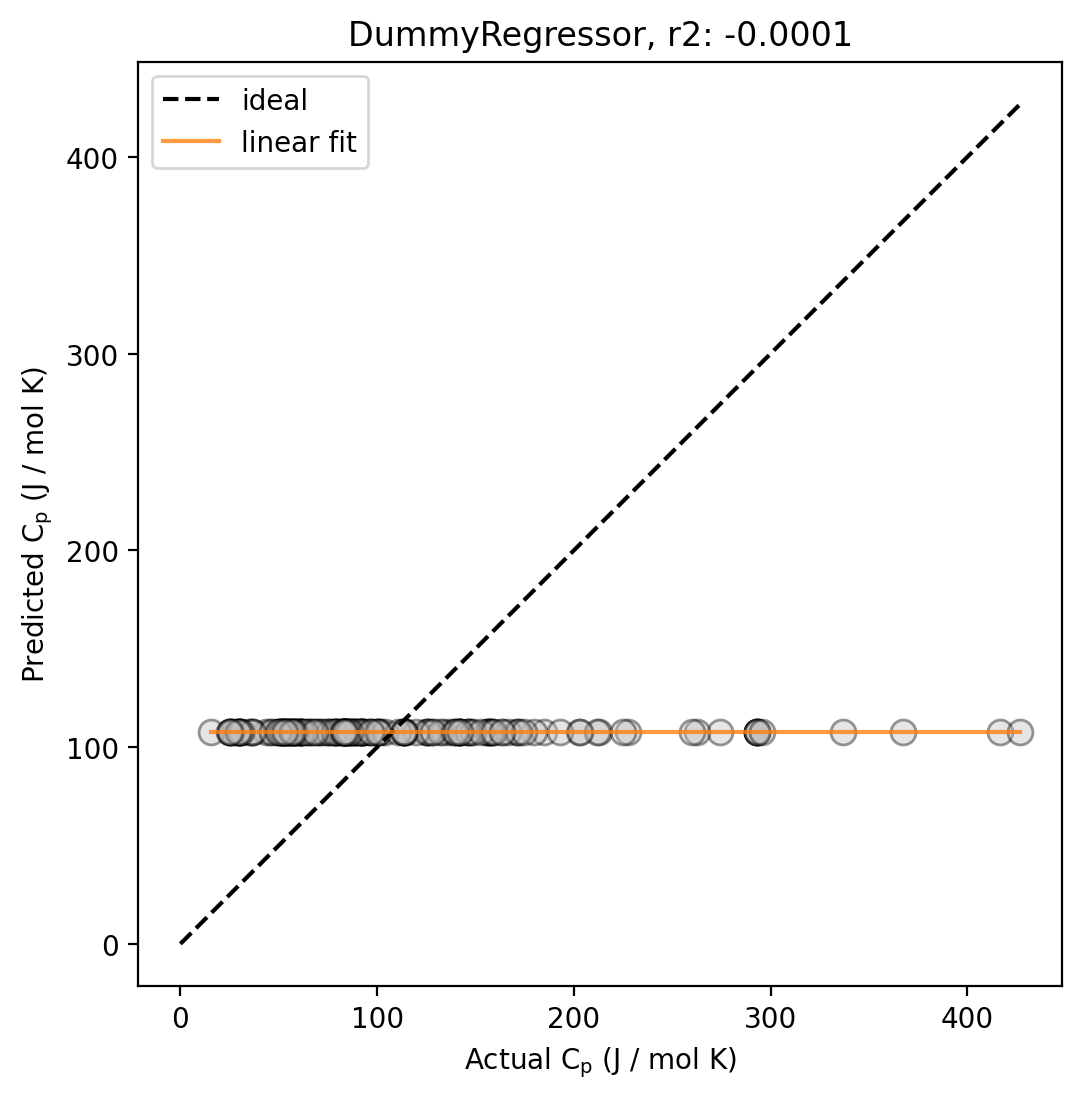

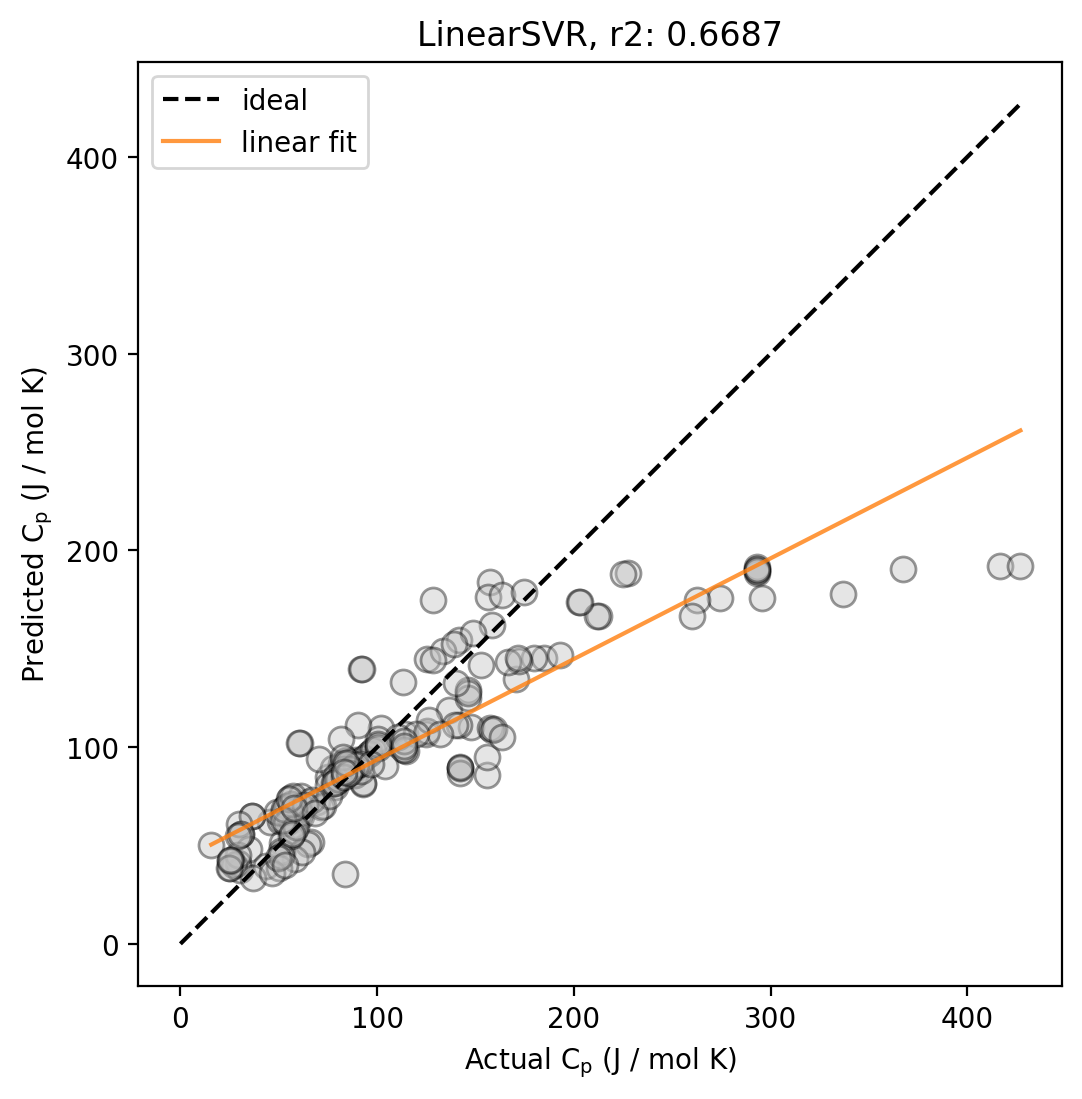

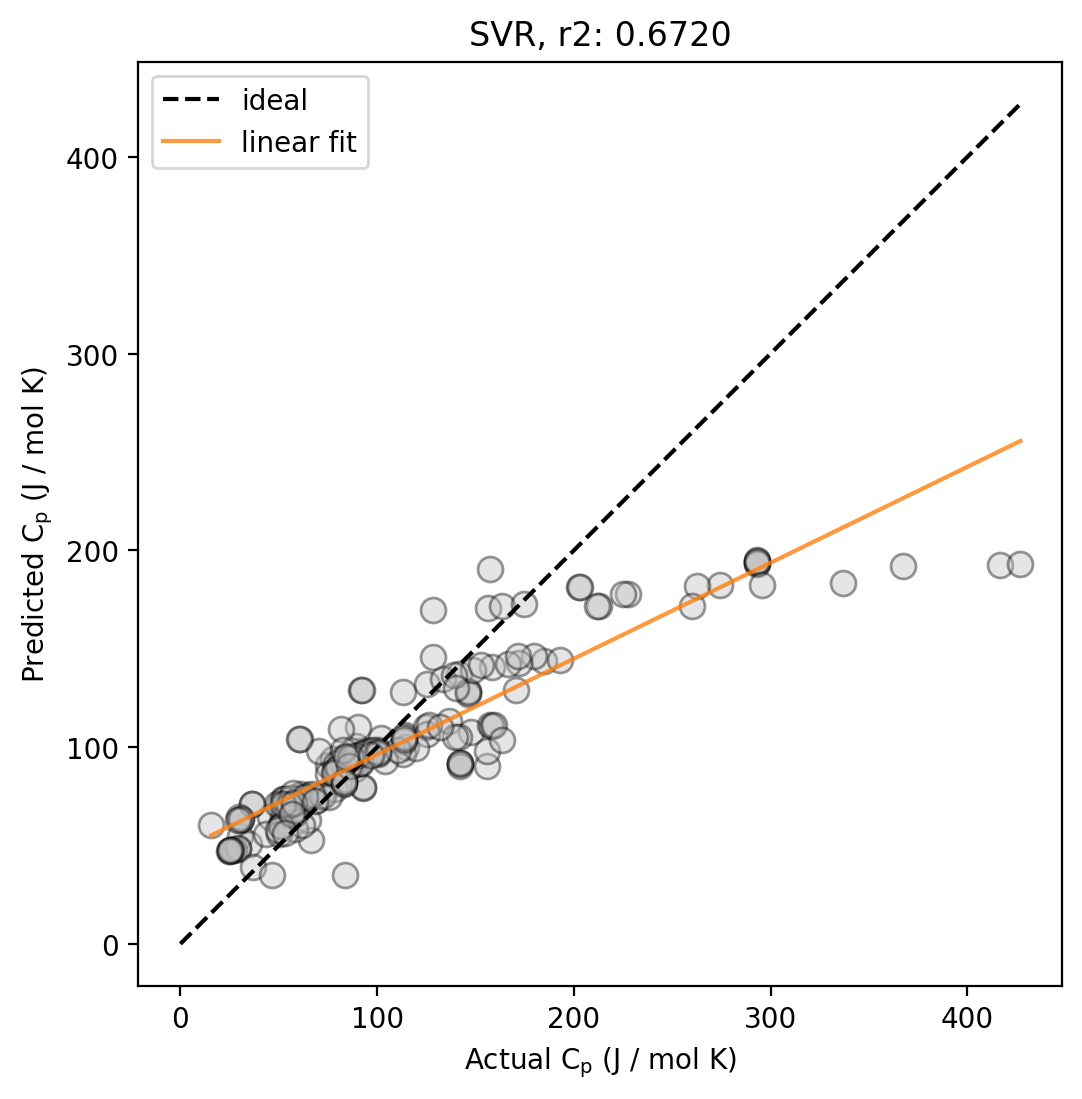

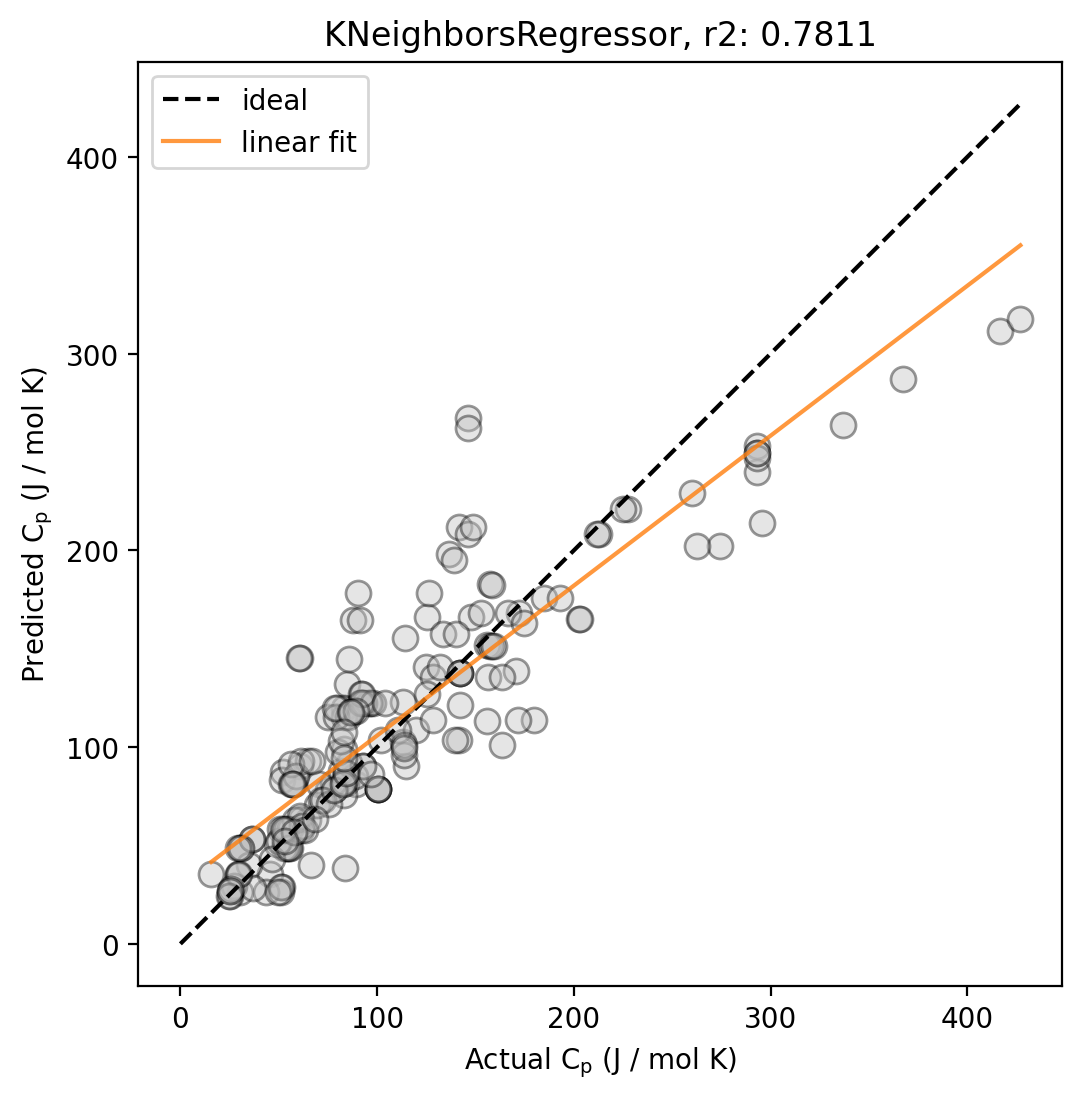

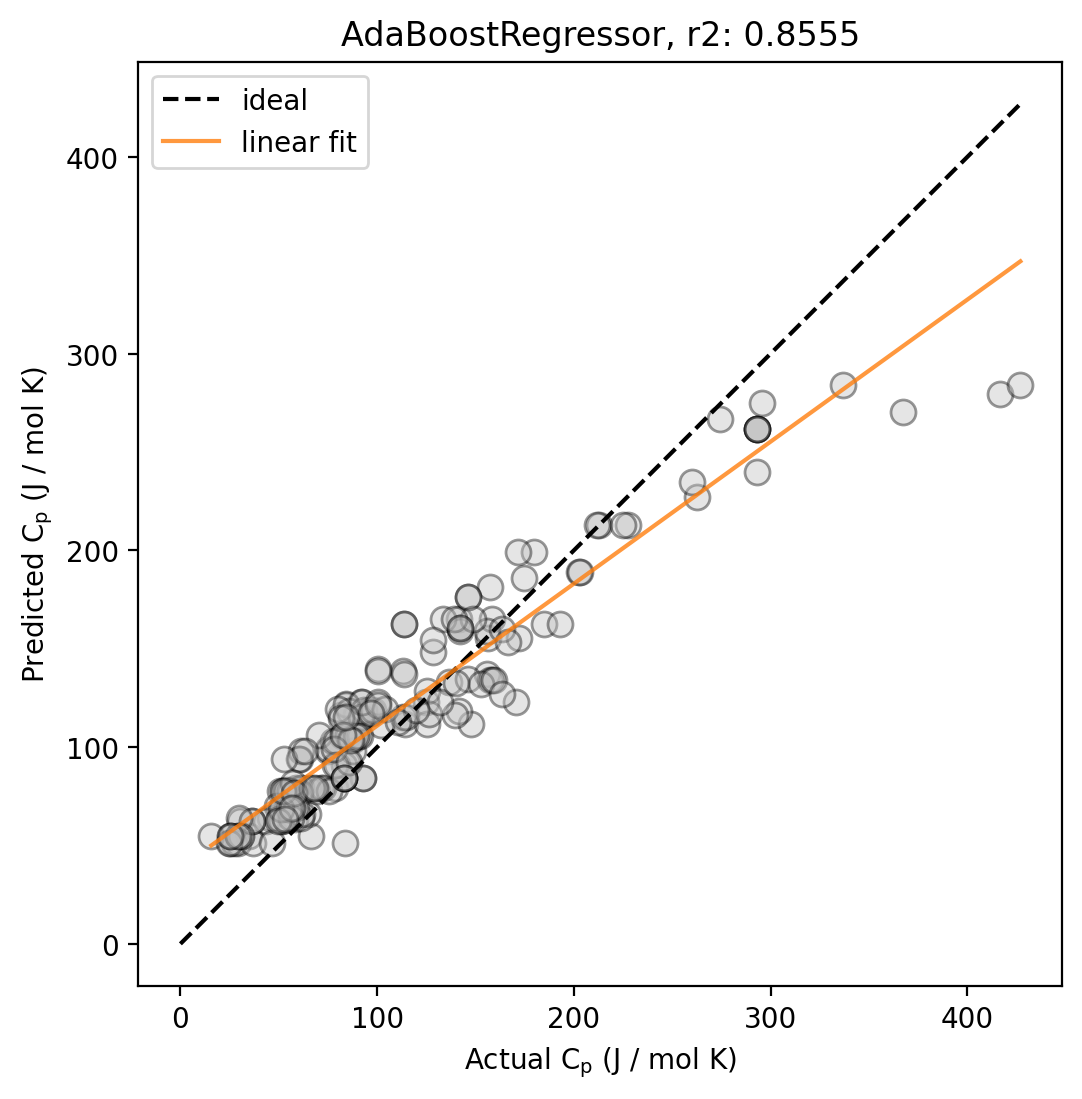

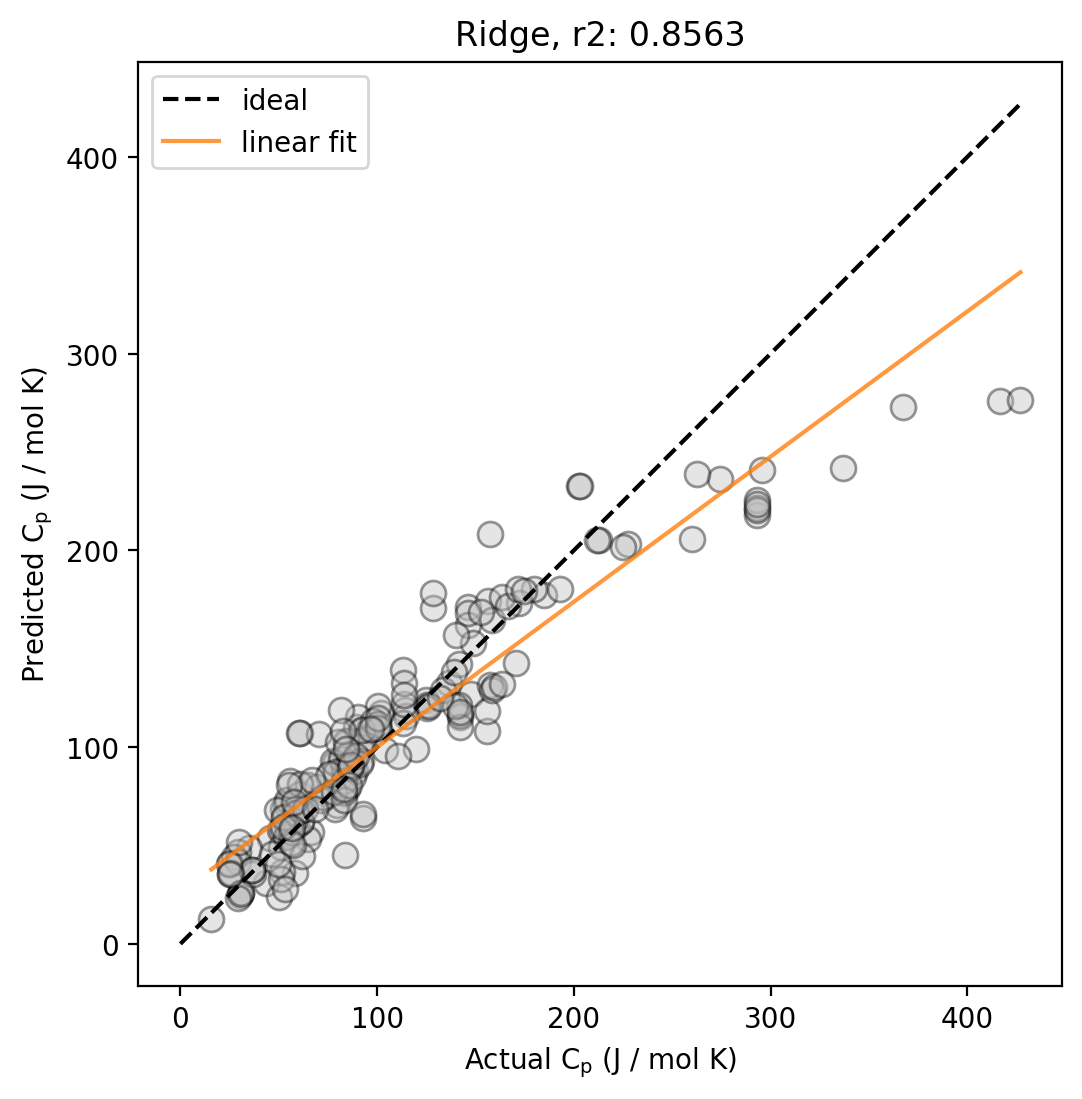

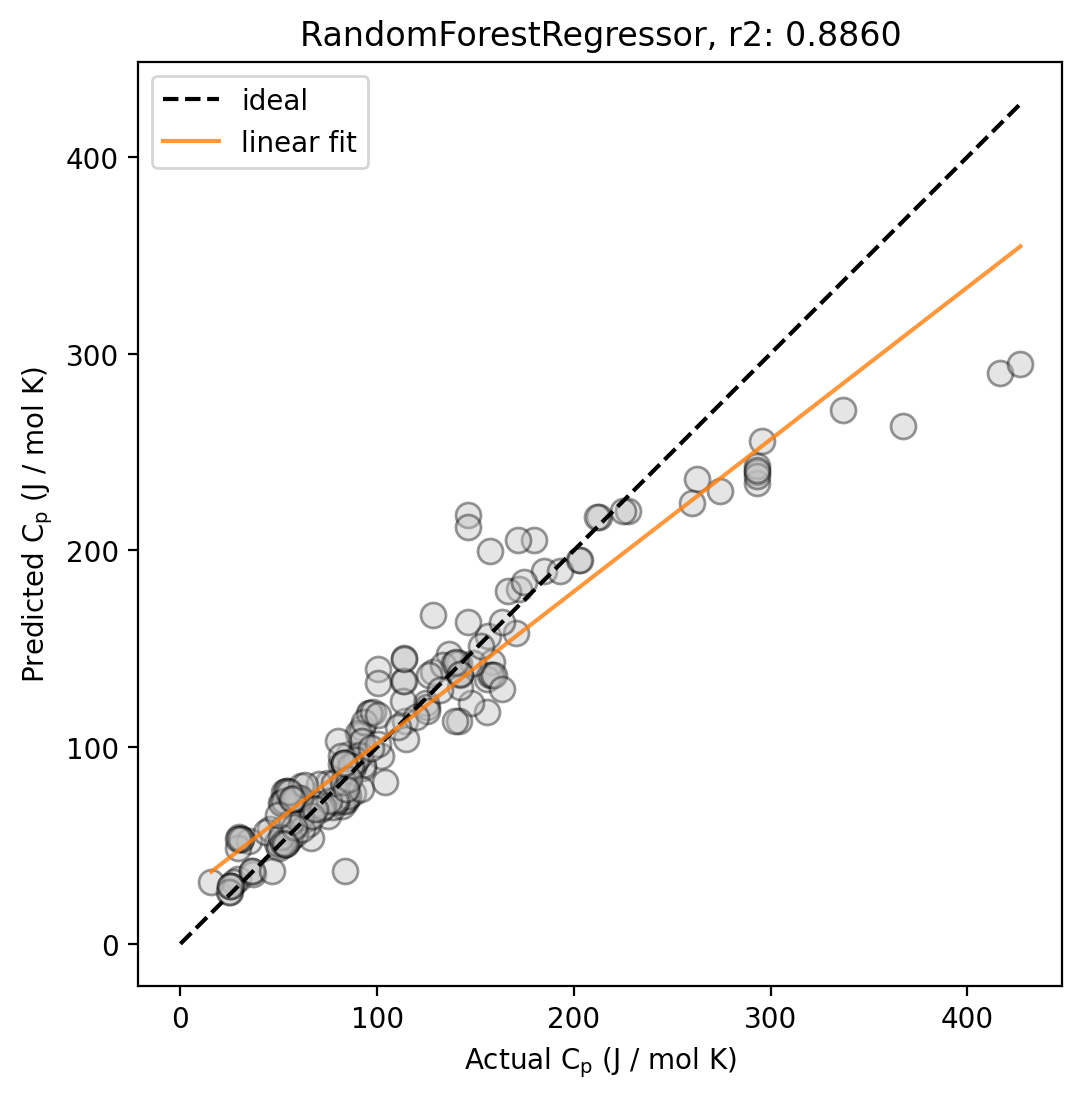

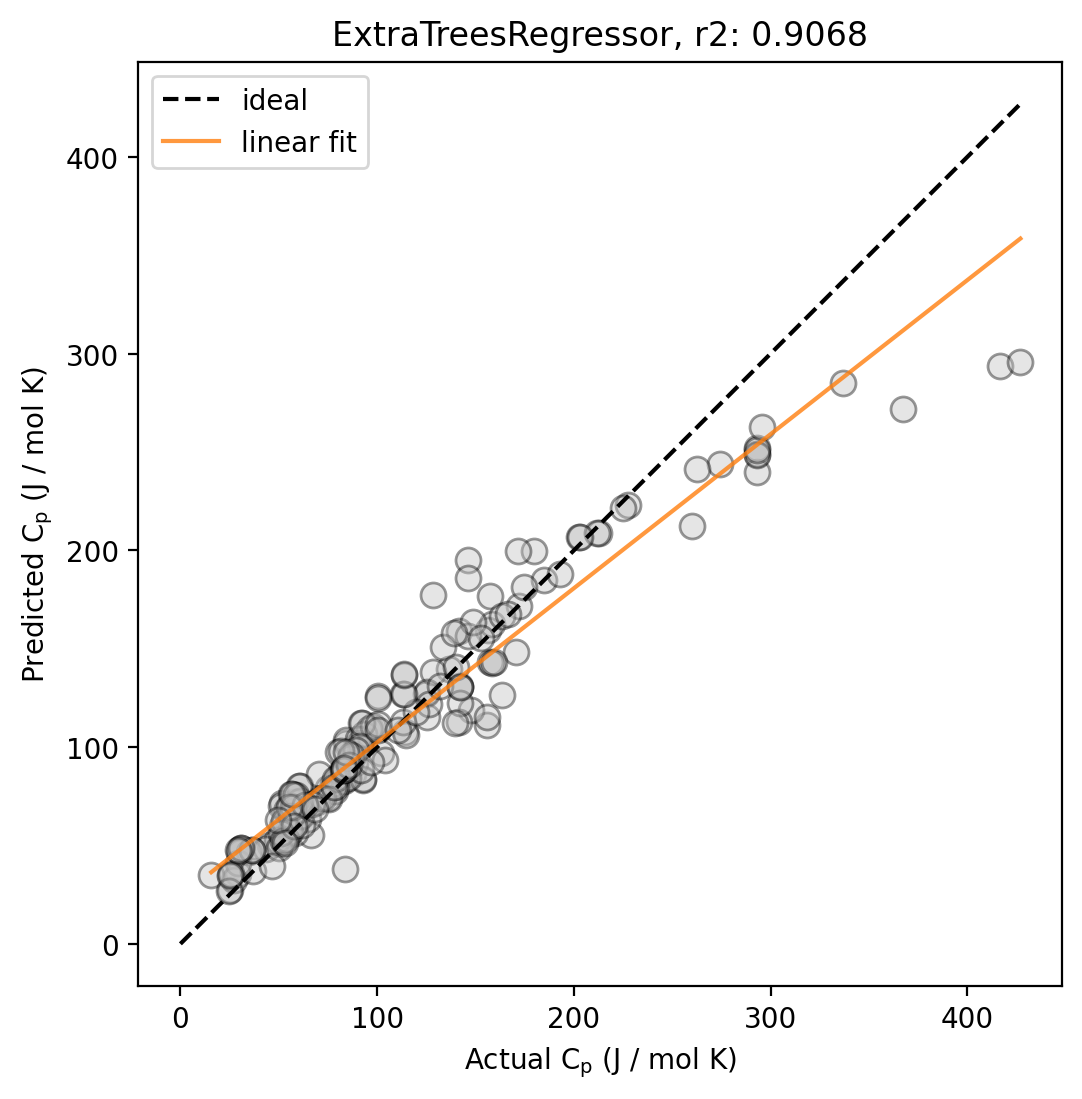

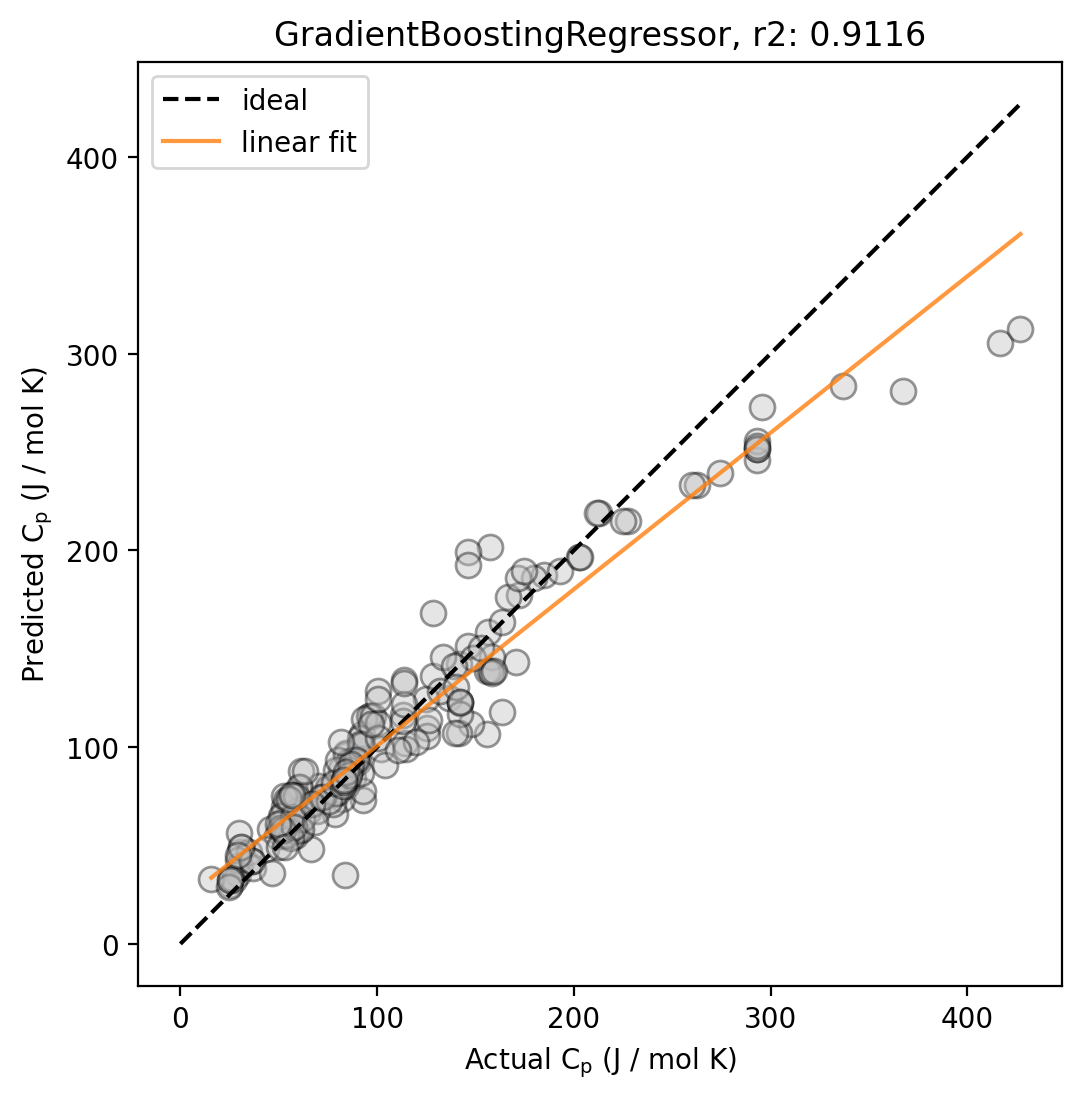

In [20]:
for row in range(df_classics.shape[0]):
    model_name = df_classics.iloc[row]['model_name']

    model = classic_models[model_name]
    y_act_val = y_val
    y_pred_val = model.predict(X_val)

    plot = plot_pred_act(y_act_val, y_pred_val, model, reg_line=True, label='$\mathrm{C}_\mathrm{p}$ (J / mol K)')

## Re-training the best-performing model on combined train + validation dataset

After you have finalized your model, you can re-train your model (using the same hyperparameters) again on the combined train + validation datasets, and finally, evaluate your model on the held-out test dataset.

By training on the combined train + validation dataset after you have finished tuning your model, you give it more training data, which should lead to an increase in the model performance.

In [21]:
# Find the best-performing model that we have tested
best_row = df_classics.iloc[-1, :].copy()

# Get the model type and model parameters
model_name = best_row['model_name']
model_params = best_row['model_params']

# Instantiate the model again using the parameters
model = classic_model_names[model_name](**model_params)
print(model)

GradientBoostingRegressor()


In [22]:
# Concatenate the train and validation datasets together
X_train_new = np.concatenate((X_train, X_val), axis=0)
y_train_new = pd.concat((y_train, y_val), axis=0)

print(X_train_new.shape)

(2200, 177)


Finally, we can fit the model on the combined train + validation dataset.

In [23]:
ti = time()

model.fit(X_train_new, y_train_new)

dt = time() - ti
print(f'Finished fitting best model, total time: {dt:0.2f} s')

Finished fitting best model, total time: 7.25 s


## Testing the re-trained model on the test dataset

After re-fitting the best model on the train+validation dataset, you can finally test it on the test dataset.
**Remember:** you should only do this *once!*

r2: 0.8317
mae: 18.2337
rmse: 32.2488


<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/var/folders/_p/4cn4bnms0pqbjk30xjltl7kw0000gn/T/ipykernel_77241/822220623.py:9: SyntaxWarning: invalid escape sequence '\m'
  plot = plot_pred_act(y_act_test, y_pred_test, model, reg_line=True, label='$\mathrm{C}_\mathrm{p}$ (J / mol K)')
/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


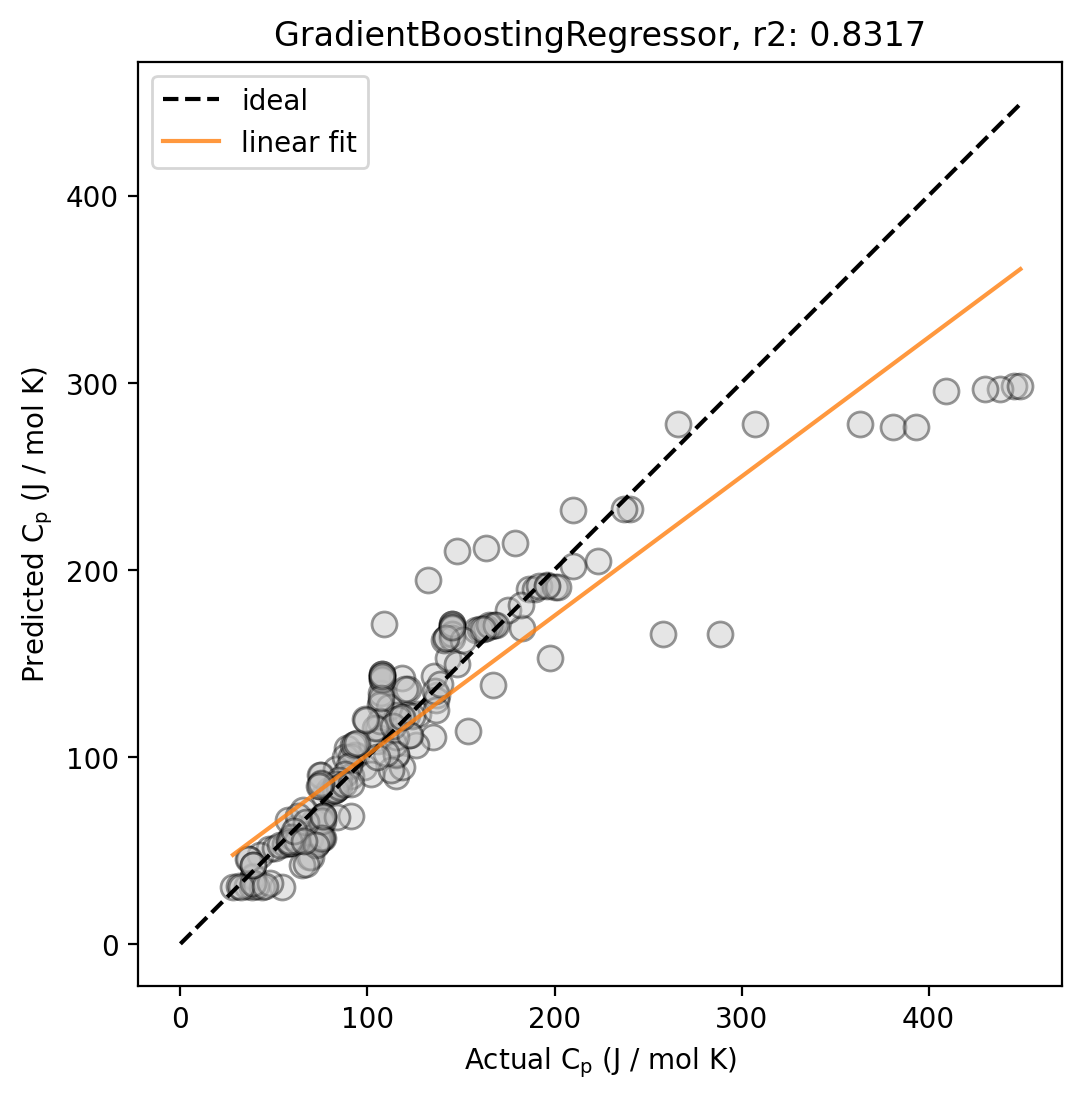

In [24]:
y_act_test = y_test
y_pred_test = model.predict(X_test)

r2, mae, rmse = evaluate_model(model, X_test, y_test)
print(f'r2: {r2:0.4f}')
print(f'mae: {mae:0.4f}')
print(f'rmse: {rmse:0.4f}')

plot = plot_pred_act(y_act_test, y_pred_test, model, reg_line=True, label='$\mathrm{C}_\mathrm{p}$ (J / mol K)')

We see that our model achieves decent performance on the held-out test dataset.

# Effect of train/validation/test dataset split

Using different train/validation/test splits can dramatically affect your model performance, even for classical ML models.

Here, we provide a little demonstration.

In [29]:
X_train_unscaled, y_train, formulae_train, skipped_train = generate_features(df_train, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_val_unscaled, y_val, formulae_val, skipped_val = generate_features(df_val, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = generate_features(df_test, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)

Processing Input Data: 100%|█████████████| 3214/3214 [00:00<00:00, 23304.03it/s]


	Featurizing Compositions...


Assigning Features...: 100%|█████████████| 3214/3214 [00:00<00:00, 20010.62it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|███████████████| 980/980 [00:00<00:00, 36620.38it/s]


	Featurizing Compositions...


Assigning Features...: 100%|███████████████| 980/980 [00:00<00:00, 21954.43it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|███████████████| 370/370 [00:00<00:00, 37325.74it/s]


	Featurizing Compositions...


Assigning Features...: 100%|███████████████| 370/370 [00:00<00:00, 21621.33it/s]


	Creating Pandas Objects...


In [30]:
X_train_original = X_train_unscaled.copy()
X_val = X_val_unscaled.copy()
X_test = X_test_unscaled.copy()

y_train_original = y_train.copy()

We sample the training data using 10 random seeds, by using the `DataFrame.sample()` method with seeds ranging from 0 to 9.
We then fit 10 models, each on one of the random splits, and evaluate their performance on the same validation dataset.

In [ ]:
splits = range(10)
df_splits = pd.DataFrame(columns=['split',
                                  'r2_train',
                                  'mae_train',
                                  'rmse_train',
                                  'r2_val',
                                  'mae_val',
                                  'rmse_val'])

for split in splits:
    print(f'Fitting and evaluating random split {split}')
    X_train = X_train_original.sample(frac=0.7, random_state=split)
    y_train = y_train_original[X_train.index]

    scaler = StandardScaler()
    X_train = normalize(scaler.fit_transform(X_train))
    X_val = normalize(scaler.transform(X_val_unscaled))
    X_test = normalize(scaler.transform(X_test_unscaled))
    
    model = AdaBoostRegressor()
    model.fit(X_train, y_train)
    y_act_val = y_val
    y_pred_val = model.predict(X_val)

    r2_train, mae_train, rmse_train = evaluate_model(model, X_train, y_train)
    r2_val, mae_val, rmse_val = evaluate_model(model, X_val, y_val)
    result_dict = {
        'split': split,
        'r2_train': r2_train,
        'mae_train': mae_train,
        'rmse_train': rmse_train,
        'r2_val': r2_val,
        'mae_val': mae_val,
        'rmse_val': rmse_val}
    
    df_splits = append_result_df(df_splits, result_dict)

Fitting and evaluating random split 0
Fitting and evaluating random split 1
Fitting and evaluating random split 2
Fitting and evaluating random split 3
Fitting and evaluating random split 4
Fitting and evaluating random split 5
Fitting and evaluating random split 6
Fitting and evaluating random split 7
Fitting and evaluating random split 8
Fitting and evaluating random split 9


In [ ]:
df_splits['split'] = df_splits['split'].astype(int)
df_splits

We then plot the train and validation $r^2$ scores for each of the 10 models.

Note the high variability in the r2_val score. In contrast, the variability in the r2_train score is comparatively lower.

In [ ]:
df_splits.plot('split', ['r2_train', 'r2_val'], kind='bar')
plt.title(f'Performance of {type(model).__name__}\nwith {len(splits)} different data splits')
plt.ylim((0.5, 1.0))
plt.ylabel('$r^2$')
plt.xlabel('Split #')
plt.legend(loc='lower right', framealpha=0.9)
plt.show()

This effect is even more pronounced when we plot the mean abolute error (MAE).

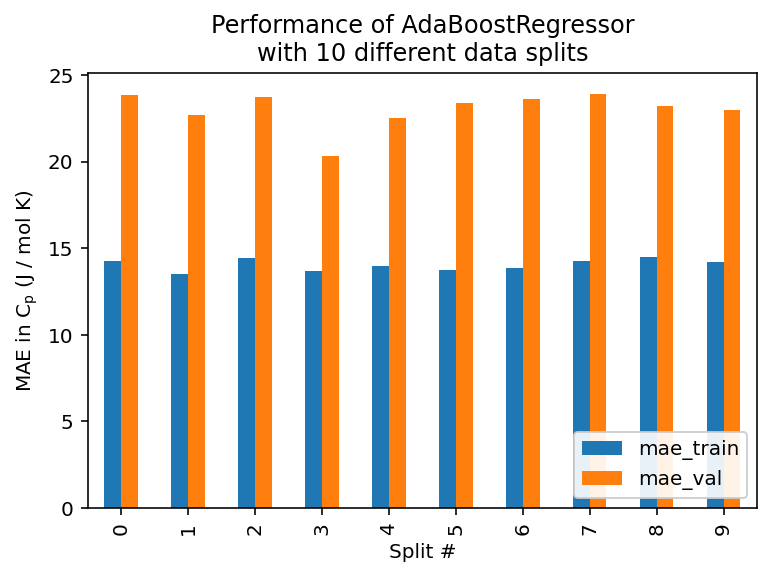

In [30]:
df_splits.plot('split', ['mae_train', 'mae_val'], kind='bar')
plt.title(f'Performance of {type(model).__name__}\nwith {len(splits)} different data splits')
plt.ylabel('MAE in $\mathrm{C}_\mathrm{p}$ (J / mol K)')
plt.xlabel('Split #')
plt.legend(loc='lower right', framealpha=0.9)
plt.show()

Therefore, typically the average value of all the scores are reported, as this gives a much more accurate estimate of how well the model actually performs.

In [31]:
avg_r2_val = df_splits['r2_val'].mean()
avg_mae_val = df_splits['mae_val'].mean()

print(f'Average validation r2: {avg_r2_val:0.4f}')
print(f'Average validation MAE: {avg_mae_val:0.4f}')

Average validation r2: 0.8198
Average validation MAE: 23.0261
